[Kaggle Dataset](https://www.kaggle.com/datasets/avk256/cnmc-leukemia)

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import math
import random
import pandas as pd
import os
import shutil
import cv2
from sklearn.metrics import roc_curve, confusion_matrix,auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Base director
base_dir = "C:\\Users\\Langa\\.cache\\kagglehub\\datasets\\andrewmvd\\leukemia-classification\\versions\\2\\C-NMC_Leukemia\\training_data"

# Paths to all (cancer) and HEM(normal) images
all_images = []
hem_images = []

#Iterate over fold0, fold1, fold2
for fold in ['fold_0', 'fold_1', 'fold_2']:
    fold_path = os.path.join(base_dir, 'fold_0')
    # adjust based in structure
    all_path = os.path.join(fold_path, 'all')
    hem_path = os.path.join(fold_path, 'hem')

    # get imagess from 'all' and 'hem' directories
    all_images.extend([os.path.join(all_path, img) for img in os.listdir(all_path) if img.endswith('.bmp')])
    hem_images.extend([os.path.join(hem_path, img) for img in os.listdir(hem_path) if img.endswith('.bmp')])

# Randomly shuffle the images
random.shuffle(all_images)
random.shuffle(hem_images)

# split into train-test-split

train_all, temp_all = train_test_split(all_images, test_size =0.2, random_state=123)
val_all, test_all = train_test_split(temp_all, test_size=0.5,random_state=123)

train_hem, temp_hem = train_test_split(hem_images, test_size=0.2, random_state=123)
val_hem, test_hem = train_test_split(temp_hem, test_size=0.5, random_state=123)

train_labels = [(img, 1) for img in train_all] + [(img, 0) for img in train_hem]
val_labels = [(img , 1) for img in val_all] + [(img, 0) for img in val_hem]
test_labels = [(img, 1) for img in test_all] + [(img, 0)for img in test_hem]

print(f'Train Size: {len(train_all) + len(train_hem)}, \n Validation Size: {len(val_all) +len(val_hem)}, \n Test Size: {len(test_all) + len(test_hem)}')

Train Size: 8464, 
 Validation Size: 1058, 
 Test Size: 1059


In [3]:
# Defining the new directory
new_dir = 'dataset_split'

for split in ['train', 'val', 'test']:
    os.makedirs(os.path.join(new_dir, split, 'all'), exist_ok=True)
    os.makedirs(os.path.join(new_dir, split, 'hem'), exist_ok=True)

# Function to copy images to new structured directory
def copy_images(image_list, distination_folder):
    for img_path in image_list:
        shutil.copy(img_path, distination_folder)

#Copy images to new structure
copy_images(train_all, os.path.join(new_dir, 'train', 'all'))
copy_images(train_hem, os.path.join(new_dir, 'train', 'hem'))
copy_images(val_all, os.path.join(new_dir, 'val', 'all'))
copy_images(val_hem, os.path.join(new_dir, 'val', 'hem'))
copy_images(test_all, os.path.join(new_dir, 'test', 'all'))
copy_images(test_hem, os.path.join(new_dir, 'test', 'hem'))

print('Images successfully copied into structured dataset')

Images successfully copied into structured dataset


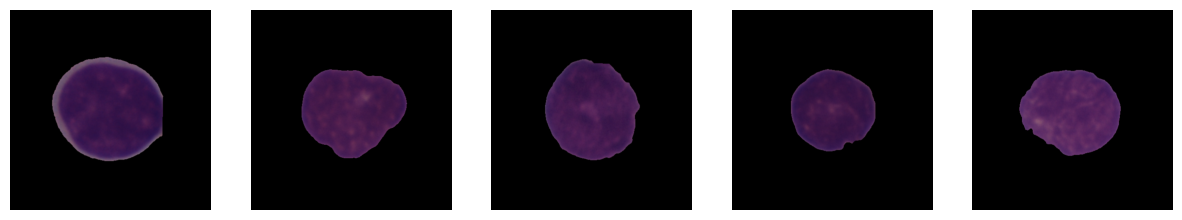

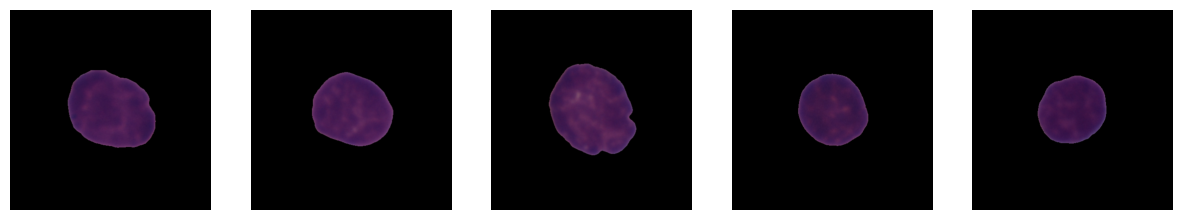

In [ ]:
# Function to load and display a few random images
def visualize_images(image_list, num_samples=5, title):
    sample_images = random.sample(image_list, num_samples)  # Select random images
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    
    for i, img_path in enumerate(sample_images):
        img = cv2.imread(img_path)  # Load image
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB
        axes[i].imshow(img)
        axes[i].axis('off')

    plt.show()

# Visualize a few samples from each class
visualize_images(train_all, num_samples=5, title='Acute Lymphoblastic Leukemia (ALL)')
visualize_images(train_hem, num_samples=5, title='Hematopoietic Cells (HEM)')


In [5]:
img_height = img_width = 32

# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,  # Normalization
    rotation_range = 15,
    zoom_range = (0.95, 1.05),  # Slight zoom variation
    horizontal_flip = True,
    vertical_flip = True,
    brightness_range = (0.8, 1.2),  # Adds brightness variation
    data_format = 'channels_last',
    dtype='float32'
)

# Validation & test generators (no augmentation, just rescaling)
validation_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    dtype='float32'
)

test_datagen = ImageDataGenerator(
    rescale = 1.0/255.0,
    dtype='float32'
)

# Ensuring all generators use the correct directories and consistent 'rgb' color mode
train_gen = train_datagen.flow_from_directory(
    os.path.join(new_dir, 'train'),  # Fixed from 'test' to 'train'
    target_size = (img_height, img_width),
    batch_size = 16,
    color_mode = 'rgb',
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

validation_gen = validation_datagen.flow_from_directory(
    os.path.join(new_dir, 'val'),
    target_size = (img_height, img_width),
    batch_size = 16,
    color_mode = 'rgb',  # Changed from 'grayscale' to 'rgb'
    class_mode = 'categorical',
    shuffle = True,
    seed = 42
)

test_gen = test_datagen.flow_from_directory(
    os.path.join(new_dir, 'test'),
    target_size = (img_height, img_width),
    batch_size = 16,  # Made consistent with training
     color_mode='rgb',  # Changed from 'rgba' to 'rgb'
    class_mode = 'categorical',
    shuffle = False,  # Typically, shuffling is off for testing to ensure consistent evaluation
    seed = 42
)

print('Data Successfully loaded into generators!')


Found 3527 images belonging to 2 classes.
Found 3479 images belonging to 2 classes.
Found 3473 images belonging to 2 classes.
Data Successfully loaded into generators!


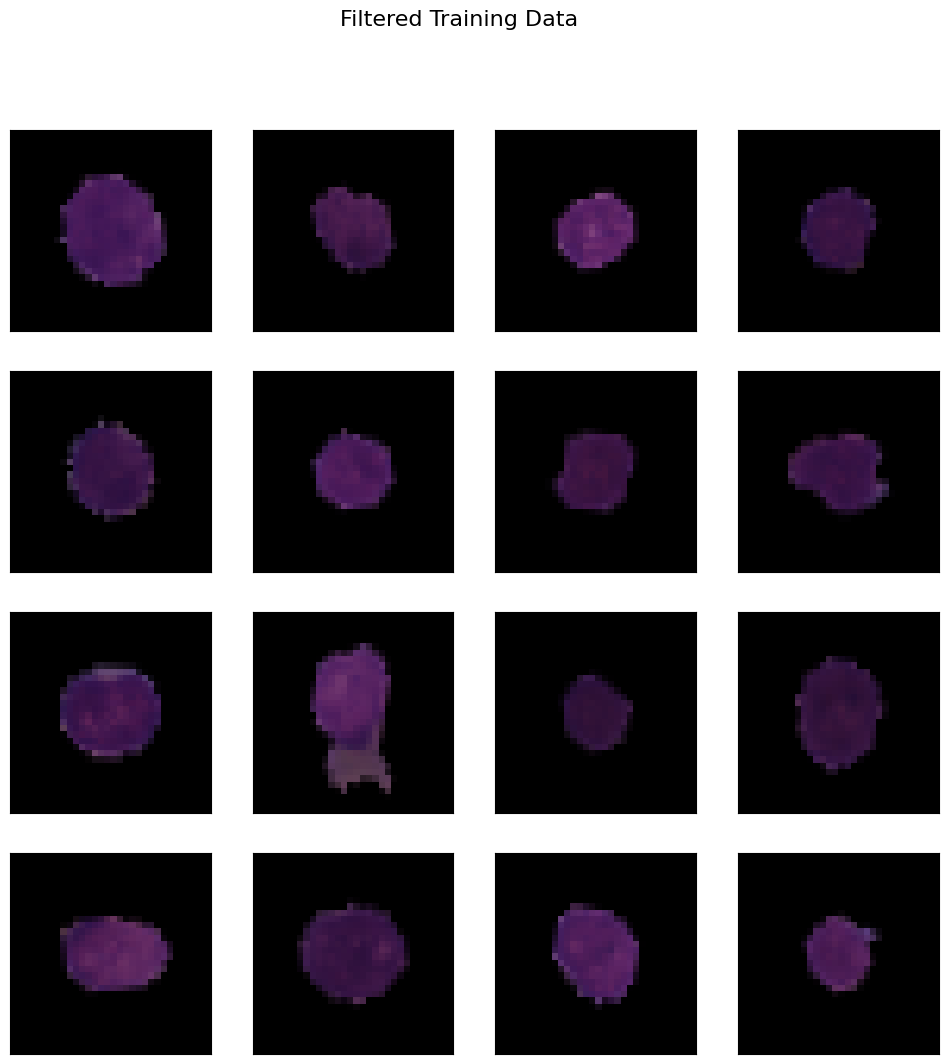

In [6]:
def plot_images(generator, title="Sample Images"):
    try:
        batch = next(generator)  # Get a batch
        images = batch[0] if batch and len(batch) > 0 else None
    except Exception as e:
        print(f"Error retrieving batch: {e}")
        return
    
    if images is None or len(images) == 0:
        print("No images found in generator!")
        return

    num_images = min(16, len(images))

    plt.figure(figsize=(12, 12))
    
    for i in range(num_images):
        plt.subplot(4, 4, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)

        img = np.squeeze(images[i])  # Prevent unwanted dimension loss
        img = (img * 255).astype("uint8")  # Convert back to image format

        # Ensure correct color mode
        if img.shape[-1] == 1:  # Grayscale case
            plt.imshow(img[:, :, 0], cmap="gray")
        else:  # RGB case
            plt.imshow(img)

    plt.suptitle(title, fontsize=16)
    plt.show()

# Test the function
plot_images(train_gen, "Filtered Training Data")


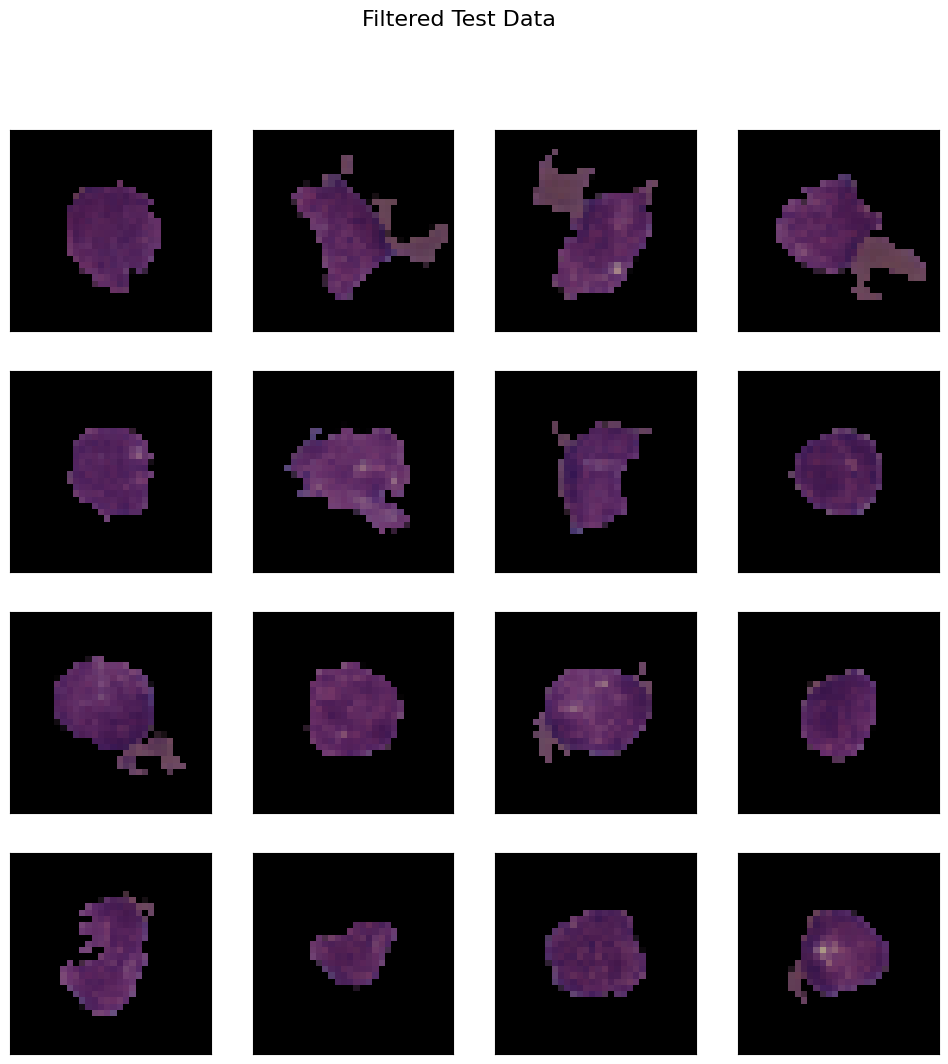

In [7]:
plot_images(test_gen, title='Filtered Test Data')

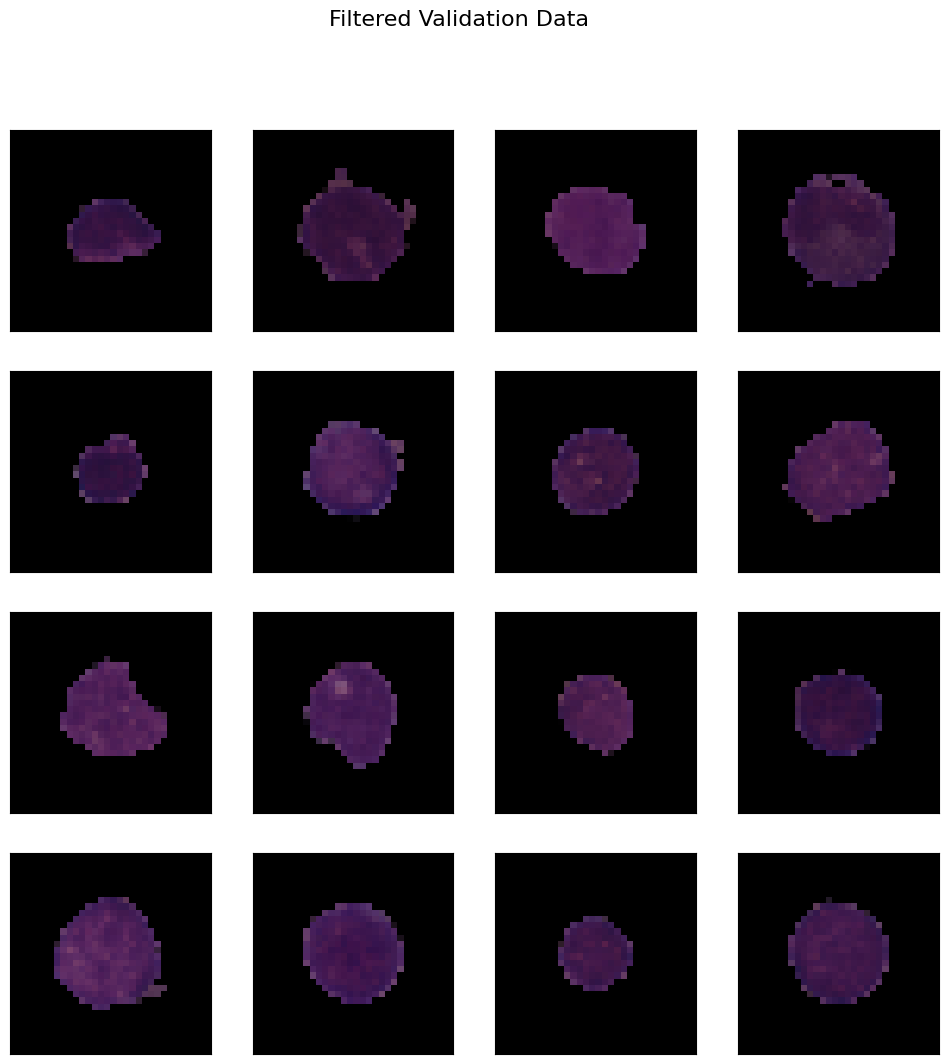

In [8]:
plot_images(validation_gen, title='Filtered Validation Data')

In [9]:
# Function to build the improved CNN model
def build_model():
    cnn_model = tf.keras.Sequential([
        # First Convolutional Layer
        layers.Conv2D(filters=32, kernel_size=(3,3), activation=None, input_shape=(32,32,3)),

        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Second Convolutional Layer
        layers.Conv2D(filters=64, kernel_size=(3,3), activation=None),
        layers.BatchNormalization(),
        layers.LeakyReLU(negative_slope=0.1),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Third Convolutional Layer
        layers.Conv2D(filters=128, kernel_size=(3,3), activation=None),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D(pool_size=(2,2)),

        # Global Average Pooling (Reduces Parameters)
        layers.GlobalAveragePooling2D(),

        # Fully Connected Layer with Dropout
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),

        # Output Layer (Binary Classification)
        layers.Dense(2, activation='softmax')
    ])
    return cnn_model

# Build and compile the model
model = build_model()
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Generate a batch of images from train_gen
batch_images, _ = next(train_gen)  

# Run predictions
predictions = model.predict(batch_images)

# Print model summary
model.summary()


C:\Users\Langa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Langa\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 644ms/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 30, 30, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 13, 13, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 110,914 (433.26 KB)

 Trainable params: 110,466 (431.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [11]:
# Suppress TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

batch_size = 32

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5),
    loss=keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

# Ensure we have enough steps per epoch
steps_per_epoch = math.ceil(train_gen.samples / batch_size)

# Train the model while handling dataset interruptions
model.fit(
    train_gen,  # Ensures the dataset doesn’t run out of batches
    epochs=20,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_gen
)

# Evaluate the model on the validation dataset
valid_loss, valid_acc = model.evaluate(validation_gen)
print('Validation accuracy:', valid_acc)


C:\Users\Langa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 295ms/step - accuracy: 0.4279 - loss: 1.0264 - val_accuracy: 0.3205 - val_loss: 0.9394
Epoch 2/20
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.6256 - loss: 0.6903

C:\Users\Langa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


111/111 ━━━━━━━━━━━━━━━━━━━━ 30s 270ms/step - accuracy: 0.6258 - loss: 0.6900 - val_accuracy: 0.3205 - val_loss: 1.1762
Epoch 3/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 33s 296ms/step - accuracy: 0.7083 - loss: 0.5991 - val_accuracy: 0.3205 - val_loss: 1.0066
Epoch 4/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 45s 409ms/step - accuracy: 0.7255 - loss: 0.5658 - val_accuracy: 0.6671 - val_loss: 0.6112
Epoch 5/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 64s 580ms/step - accuracy: 0.7340 - loss: 0.5846 - val_accuracy: 0.8109 - val_loss: 0.4681
Epoch 6/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 51s 467ms/step - accuracy: 0.7775 - loss: 0.4925 - val_accuracy: 0.8186 - val_loss: 0.4399
Epoch 7/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 78s 707ms/step - accuracy: 0.7684 - loss: 0.5383 - val_accuracy: 0.7997 - val_loss: 0.4651
Epoch 8/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 65s 586ms/step - accuracy: 0.7606 - loss: 0.5245 - val_accuracy: 0.8140 - val_loss: 0.4419
Epoch 9/20
111/111 ━━━━━━━━━━━━━━━━━━━━ 54s 490ms/step - accuracy: 0.7857 - loss: 0.4829 - val

C:\Users\Langa\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


218/218 ━━━━━━━━━━━━━━━━━━━━ 25s 109ms/step
Test Accuracy: 82.21%


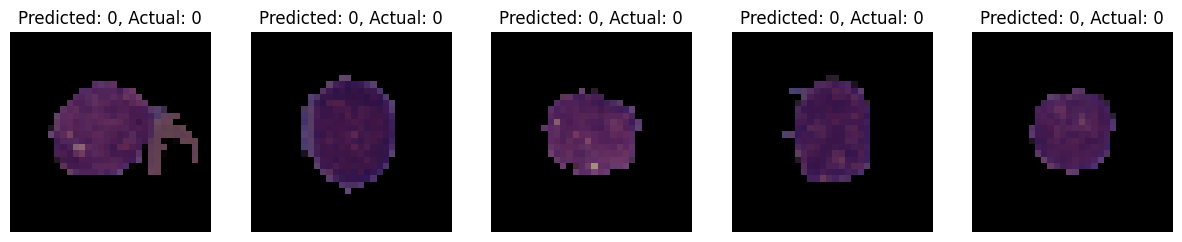

In [12]:
# Generate predictions
predictions = model.predict(test_gen)

# Convert probabilities to class labels
predicted_classes = np.argmax(predictions, axis=1)
true_labels = test_gen.classes  # True labels from generator

# Check accuracy of predictions
correct = np.sum(predicted_classes == true_labels)
accuracy = correct / len(true_labels)
print(f"Test Accuracy: {accuracy:.2%}")

# Visualize predictions
batch_images, _ = next(test_gen)
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i in range(5):  # Show first 5 test images
    axes[i].imshow(batch_images[i])
    axes[i].axis('off')
    axes[i].title.set_text(f"Predicted: {predicted_classes[i]}, Actual: {true_labels[i]}")

plt.show()


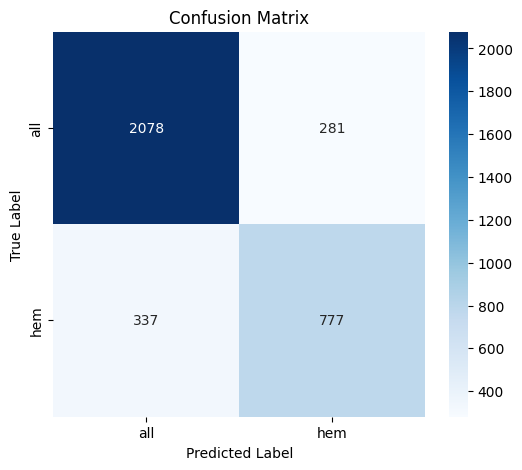

In [13]:
# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

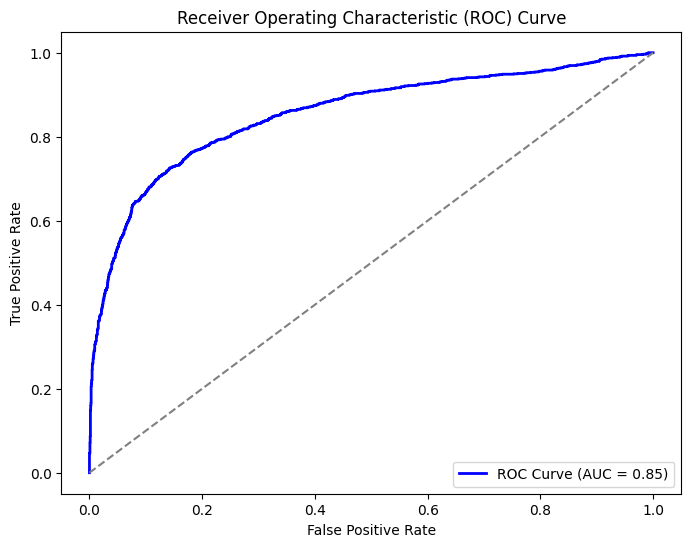

In [14]:

# Extract predicted probabilities for the positive class
positive_class_probabilities = predictions[:, 1]  # binary classification (0, 1)

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(true_labels, positive_class_probabilities)

# Compute AUC (Area Under Curve)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Random guess line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

In [18]:
# Save the model
model.save("my_model.keras")

## **_Conclusion_**

- The analysis confirms that the model effectively recognizes patterns in the data, with its predictions consistently aligning with the actual class labels. This demonstrates strong learning capability and accurate differentiation between categories within the dataset.

- From the confusion matrix, the model correctly classified 2,078 ALL images as positive (1) and 777 HEM images as negative (0). With an impressive 82.21% accuracy on the test dataset, the model showcases significant potential for medical image classification. Its ability to reliably differentiate between ALL and HEM cells could pave the way for assisting hematologists in early diagnosis and treatment planning.